# ML 7: Groundtruths

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

**Plate description**:\
Plate number 120\
Strain: C2\
Treatment: 100C\
Crossdate: 01/07\
Prince position: 18

**General presentation**\
This plate was fully imaged in Prince with different focuses and luminosity: 26 different run in total.
Groundtruth close-up images were also taken at high magnification in 6 location of the plate for a total of 130 close up images.\
The close up images were taken with a tilted plate to have a more precise focus choice.\
We labeled the groundtruth images with _labelme_, setting labels with names `width_023` ranging from 001 to 100 (some images can leand to several groundtruth labels).
We also labeled the same exact location on prince image for each groundtruth, by using the coordinate transformation from joystick referential to Prince referential, identifying the tile and setting a label also with _labelme_.
The names range from 001 to 100.
The Prince labels were set on the image that was found to be the more focused.

**Warning**:\
Close up images aren't all taken with the same magnification.

**Remarks**:\
Because of the overlap on Prince images, some groundtruth can lead to several segments on Prince images.


**This notebook**\
This notebook is for dataset generation

## Setup

### Imports

In [2]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import json
import imageio
import logging
import cv2
from skimage.measure import profile_line

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    plot_full,
)

from amftrack.util.sys import (
    get_current_folders,
    update_plate_info,
    test_path
)
from amftrack.util.plot import show_image
from amftrack.util.sys import storage_path
from amftrack.util.geometry import (
    generate_index_along_sequence, 
    centered_bounding_box, expand_segment, 
    get_section_segment,
    compute_factor,
    generate_index_along_sequence,
    distance_point_pixel_line,
    get_closest_lines,
    get_closest_line_opt,
    intersect_rectangle,
    is_overlapping,
    get_overlap,
    format_region,
    is_in_bounding_box,
    get_bounding_box,
    centered_bounding_box
)
from amftrack.util.image_analysis import (
    find_transformation,
    get_transformation,
    reverse_transformation,
    convert_to_micrometer,
    find_image_index,
    is_in_image,
    extract_inscribed_rotated_image,
    is_negative_similarity,
    find_similarity,
    find_scaling_factor,
)

/home/felix/Wks/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data

### Imaging parameters

In [3]:
d = {
    # Varying focus with normal luminosity of 1100
    "20220714_1405_Plate18": {"focus": 0.5, "luminosity": 1100},
    "20220714_1409_Plate18": {"focus": 0.4, "luminosity": 1100},
    "20220714_1413_Plate18": {"focus": 0.3, "luminosity": 1100},
    "20220714_1417_Plate18": {"focus": 0.2, "luminosity": 1100},
    "20220714_1422_Plate18": {"focus": 0.1, "luminosity": 1100},
    "20220714_1426_Plate18": {"focus": 0., "luminosity": 1100},
    "20220714_1430_Plate18": {"focus": -0.1, "luminosity": 1100},
    "20220714_1434_Plate18": {"focus": -0.2, "luminosity": 1100},
    "20220714_1438_Plate18": {"focus": -0.3, "luminosity": 1100},
    "20220714_1444_Plate18": {"focus": -0.4, "luminosity": 1100},
    "20220714_1451_Plate18": {"focus": -0.5, "luminosity": 1100},
    
    # Varying focus for luminosity of 900
    "20220714_1520_Plate18": {"focus": 0., "luminosity": 900},
    "20220714_1505_Plate18": {"focus": -0.1, "luminosity": 900},
    "20220714_1543_Plate18": {"focus": -0.2, "luminosity": 900},
    
    # Varying focus for luminosity of 1000
    "20220714_1526_Plate18": {"focus": 0., "luminosity": 1000},
    "20220714_1511_Plate18": {"focus": -0.1, "luminosity": 1000},
    "20220714_1547_Plate18": {"focus": -0.2, "luminosity": 1000},
    
    # Varying focus for luminosity of 1200
    "20220714_1530_Plate18": {"focus": 0., "luminosity": 1200},
    "20220714_1515_Plate18": {"focus": -0.1, "luminosity": 1200},
    "20220714_1551_Plate18": {"focus": -0.2, "luminosity": 1200},
    
    # Varying focus for luminosity of 1300
    "20220714_1535_Plate18": {"focus": 0., "luminosity": 1300},
    "20220714_1501_Plate18": {"focus": -0.1, "luminosity": 1300},
    "20220714_1558_Plate18": {"focus": -0.2, "luminosity": 1300},
    
    # Varying focus for luminosity of 1500
    "20220714_1539_Plate18": {"focus": 0., "luminosity": 1500},
    # "20220714_1457_Plate18": {"focus": -0.1, "luminosity": 1500},   # Missing stiching
    "20220714_1602_Plate18": {"focus": -0.2, "luminosity": 1500}, 
}

In [4]:
len(d)

25

### Groundtruth repository

In [5]:
directory_groundtruths = os.path.join(storage_path, "20220714_plate_120_groundtruths_close_up")

### General parameters

In [6]:
directory = os.path.join(storage_path, "20220714_plate_120_groundtruths_width_extraction") + "/"

### Experiment object setup

In [7]:
update_plate_info(directory)
folder_df = get_current_folders(directory)

analysed:   0%|          | 0/26 [00:00<?, ?it/s]

In [8]:
folder_df['Plate'].unique()

array(['120focus'], dtype=object)

In [9]:
select = folder_df[folder_df['Plate']=='120focus']

In [10]:
len(select)

26

In [11]:
set(select['unique_id'])

{'120focus_20220701'}

Only load part of the timesteps

In [12]:
exp = Experiment(directory)
exp.load_light(select, suffix="")

Finding first and last steps

In [13]:
pd.set_option('display.max_rows', 500)
select['date'].sort_values()

0     14.07.2022, 14:05:
1     14.07.2022, 14:09:
2     14.07.2022, 14:13:
3     14.07.2022, 14:17:
4     14.07.2022, 14:22:
5     14.07.2022, 14:26:
6     14.07.2022, 14:30:
7     14.07.2022, 14:34:
8     14.07.2022, 14:38:
9     14.07.2022, 14:44:
10    14.07.2022, 14:51:
11    14.07.2022, 14:57:
12    14.07.2022, 15:01:
13    14.07.2022, 15:05:
14    14.07.2022, 15:11:
15    14.07.2022, 15:15:
16    14.07.2022, 15:20:
17    14.07.2022, 15:26:
18    14.07.2022, 15:30:
19    14.07.2022, 15:35:
20    14.07.2022, 15:39:
21    14.07.2022, 15:43:
22    14.07.2022, 15:47:
23    14.07.2022, 15:51:
24    14.07.2022, 15:58:
25    14.07.2022, 16:02:
Name: date, dtype: object

In [14]:
for t in range(len(exp)):
    try:
        exp.load_tile_information(t)
    except:
        print(f"Error at t: {t}")

Error at t: 11


## 0/ General visualisation of the plate and visual check-up

### Full plate

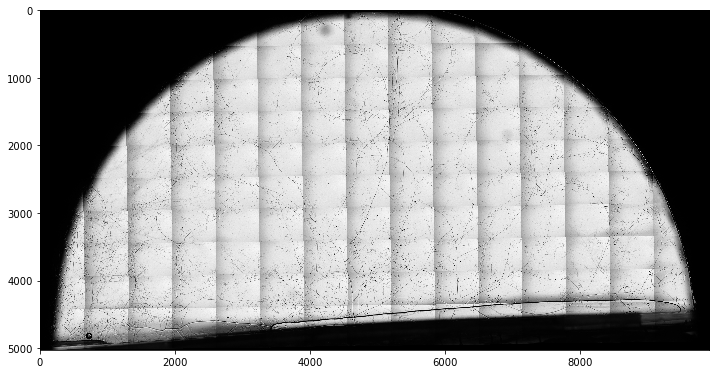

In [27]:
#%matplotlib inline
t = 12
exp.load_tile_information(t)
plot_full_image_with_features(exp, t, downsizing = 10)

### Specific tiles

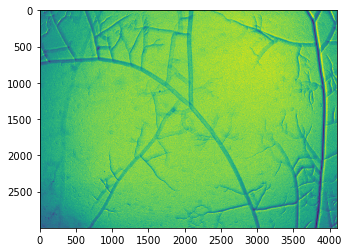

In [40]:
show_image(exp.image_paths[0][11])

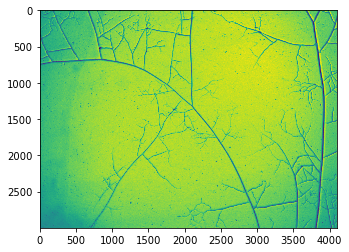

In [41]:
show_image(exp.image_paths[5][11])

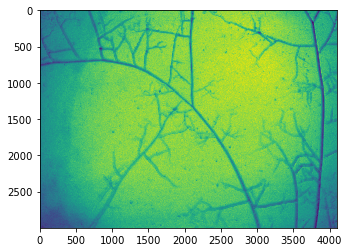

In [42]:
show_image(exp.image_paths[9][11])

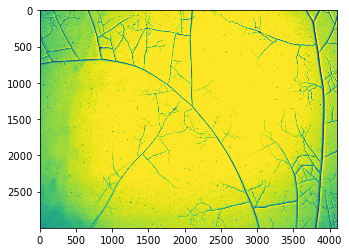

In [44]:
show_image(exp.image_paths[20][11])

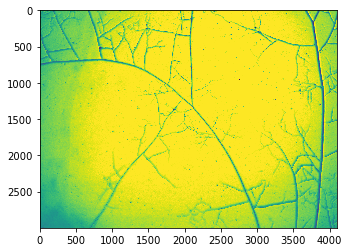

In [46]:
show_image(exp.image_paths[25][11])

### Groundtruths

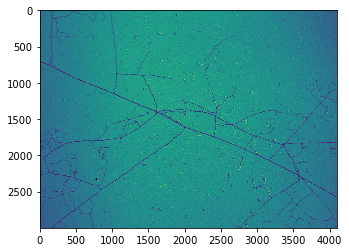

In [48]:
show_image(os.path.join(directory_groundtruths, "07_snapshot.tiff"))

### Consistency of coordinates on one tile accross runs

#### Accross focus with default illumination

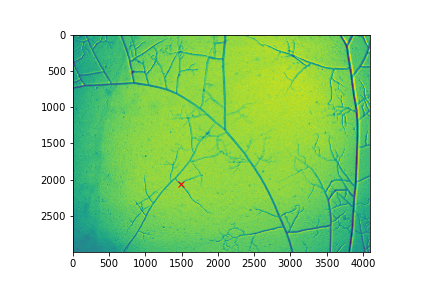

In [214]:
%matplotlib widget
show_image(exp.image_paths[3][11])
plt.plot(1487, 2057, marker="x", color="red")

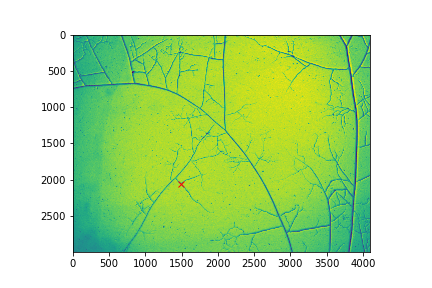

In [211]:
%matplotlib widget
show_image(exp.image_paths[5][11])
plt.plot(1487, 2057, marker="x", color="red")

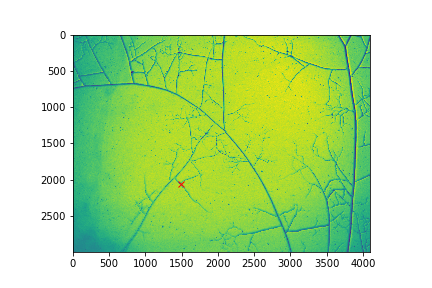

In [212]:
%matplotlib widget
show_image(exp.image_paths[6][11])
plt.plot(1487, 2057, marker="x", color="red")

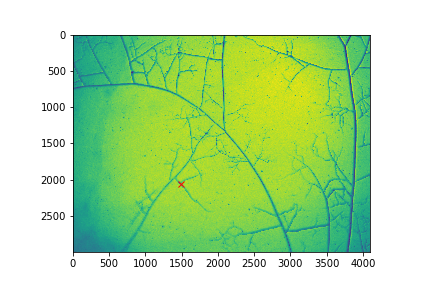

In [213]:
%matplotlib widget
show_image(exp.image_paths[7][11])
plt.plot(1487, 2057, marker="x", color="red")

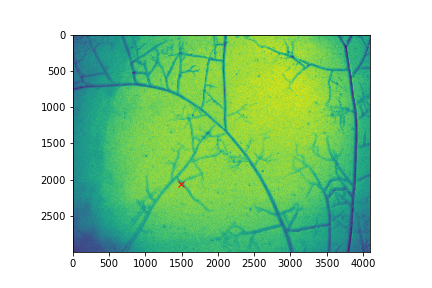

In [215]:
%matplotlib widget
show_image(exp.image_paths[9][11])
plt.plot(1487, 2057, marker="x", color="red")

#### Accros illumination for the same focus

In [216]:
names = ['20220714_1505_Plate18', '20220714_1501_Plate18', '20220714_1430_Plate18']

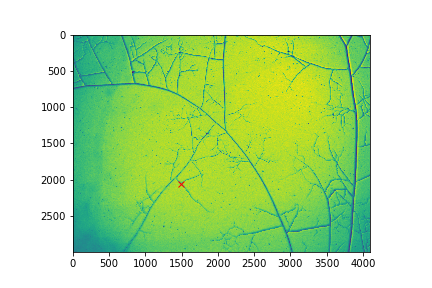

In [218]:
%matplotlib widget
show_image(exp.image_paths[exp.name_to_t(names[0])][11])
plt.plot(1487, 2057, marker="x", color="red")

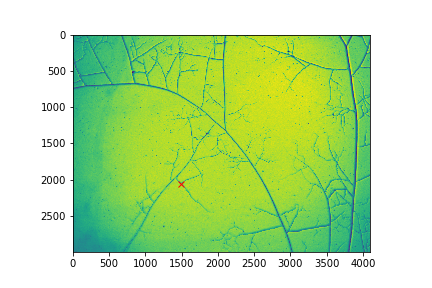

In [219]:
%matplotlib widget
show_image(exp.image_paths[exp.name_to_t(names[1])][11])
plt.plot(1487, 2057, marker="x", color="red")

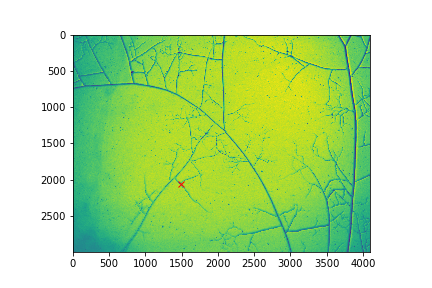

In [220]:
%matplotlib widget
show_image(exp.image_paths[exp.name_to_t(names[2])][11])
plt.plot(1487, 2057, marker="x", color="red")

## 1/ Identify plane transformation

### Full image

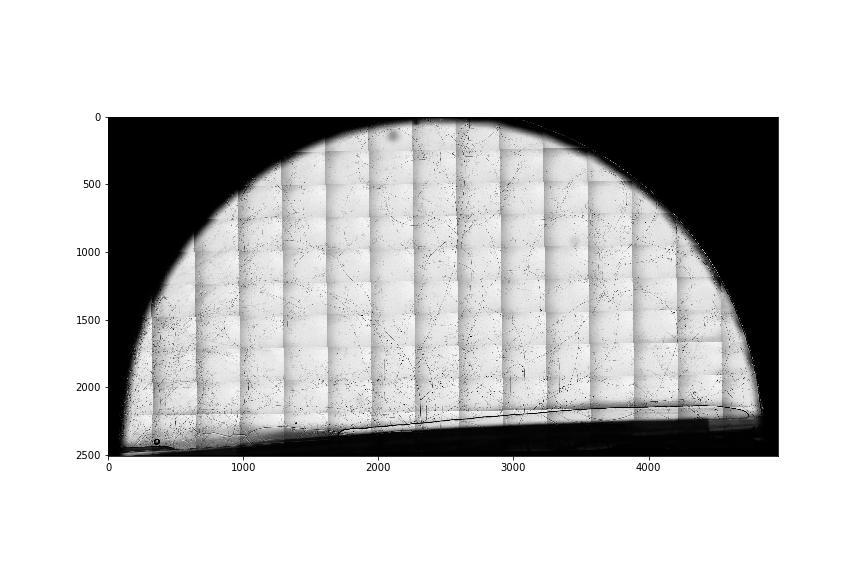

In [53]:
%matplotlib widget
plot_full_image_with_features(exp, 6, downsizing = 10)

### Snapshot

In [52]:
show_image(os.path.join(directory_groundtruths, "03_snapshot.tiff"))

### Find transformation

In [78]:
joystick_coord = [
    [49580, 62680], # snapshot 09
    [24900, 47000], # snapshot 13
    [34660, 59420], # snapshot 14
    [48580, 47180], # snapshot 04
    [59180, 52580], # snapshot 15
    [4680, 60300], # snapshot 6
    [14860, 46120], # snapshot 5
]
plt_10_coord = [
    [3476, 1587],
    [2141, 777],
    [2716, 1515],
    [3346, 667],
    [4084, 1040],
    [860, 1556],
    [1392, 709]
]
general_coord = [np.array([c[1], c[0]])*10 for c in plt_10_coord]

In [79]:
f = find_similarity(joystick_coord, general_coord)

[0.5340374068610828, 0.4998709283999902, 0.5982011029624504, 0.5869225116758178, 0.5818521250276396, 0.5878807184335852, 0.5922748811622519, 0.5109693304572024, 0.564541371164914, 0.6194798412259414, 0.7462231963915321, 0.5699232966206252, 0.568867895431167, 0.6189638304081444, 0.6498489228965251, 0.6950996406687934, 0.5762230805033609, 0.5793257321205272, 0.5931669603982959, 0.6055759106963418, 0.5729996498220402]
Similarity ratio: 0.5869225116758178
Similarity is a negative similarity
Rotation: [[ 0.99937018 -0.03548578]
 [ 0.03548578  0.99937018]]
Translation: [-19526.73212984   4807.04779779]


### Visualize transformation

In [80]:
snapshot_coord_joystick = [
    [0, 0],
    [28840, 59840],
    [28920, 67220],
    [43180, 66980],
    [48580, 47180],
    [14860, 46120],
    [4680, 60300],
    [16560, 50580],
    [52720, 54300],
    [49580, 62680],
    [51660, 66580],
    [42020, 64500],
    [32520, 55540],
    [24900, 47000],
    [34660, 59420],
    [59180, 52580], 
    [46900, 55780],
]

In [81]:
len(snapshot_coord_joystick)

17

In [82]:
snapshot_coord = [f(e) for e in snapshot_coord_joystick]

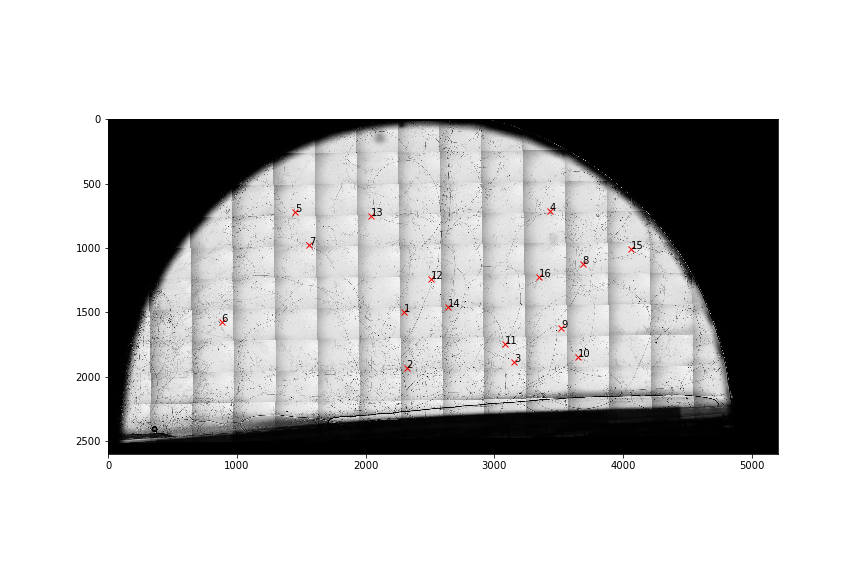

In [84]:
%matplotlib widget
plot_full(exp, t=7, downsizing = 10, region = [[0, 0], [26000, 52000]], points = snapshot_coord, with_point_label = True)

### Identification des tiles

## 2/ Choosing focus and illumination for training

### Selecting runs

In [38]:
run_df = pd.DataFrame(d)
run_df = run_df.T
run_df

focus  luminosity
20220714_1405_Plate18    0.5      1100.0
20220714_1409_Plate18    0.4      1100.0
20220714_1413_Plate18    0.3      1100.0
20220714_1417_Plate18    0.2      1100.0
20220714_1422_Plate18    0.1      1100.0
20220714_1426_Plate18    0.0      1100.0
20220714_1430_Plate18   -0.1      1100.0
20220714_1434_Plate18   -0.2      1100.0
20220714_1438_Plate18   -0.3      1100.0
20220714_1444_Plate18   -0.4      1100.0
20220714_1451_Plate18   -0.5      1100.0
20220714_1520_Plate18    0.0       900.0
20220714_1505_Plate18   -0.1       900.0
20220714_1543_Plate18   -0.2       900.0
20220714_1526_Plate18    0.0      1000.0
20220714_1511_Plate18   -0.1      1000.0
20220714_1547_Plate18   -0.2      1000.0
20220714_1530_Plate18    0.0      1200.0
20220714_1515_Plate18   -0.1      1200.0
20220714_1551_Plate18   -0.2      1200.0
20220714_1535_Plate18    0.0      1300.0
20220714_1501_Plate18   -0.1      1300.0
20220714_1558_Plate18   -0.2      1300.0
20220714_1539_Plate18    0.0      1500.0
20220714_1602_Plate18   -0.2      1500.0

### Which runs to chose

The width is very well discernable with varying luminosity (even at 1500 and 900).\
On the contrary it becomes very fast hard with varying focus.\
General optimal focus is -0.1.

As a result:
- we use all luminosity for training
- focus timesteps between 0 and -0.2

In [39]:
training_df = select_df(run_df, focus = [-0.2, 0], luminosity = [900, 1500])
training_df

NameError: name 'select_df' is not defined

In [ ]:
training_runs = select_runs(run_df, focus=[-0.2, 0.], luminosity=[900, 1500])
len(training_runs)

In [17]:
training_runs

NameError: name 'training_runs' is not defined

In [18]:
training_indexes = [exp.name_to_t(name) for name in training_runs]

NameError: name 'training_runs' is not defined

In [19]:
training_indexes
print(training_indexes)

NameError: name 'training_indexes' is not defined

In [207]:
correspondance = list(zip(training_indexes, training_runs))

In [209]:
correspondance.sort()

In [210]:
correspondance

[(5, '20220714_1426_Plate18'),
 (6, '20220714_1430_Plate18'),
 (7, '20220714_1434_Plate18'),
 (12, '20220714_1501_Plate18'),
 (13, '20220714_1505_Plate18'),
 (14, '20220714_1511_Plate18'),
 (15, '20220714_1515_Plate18'),
 (16, '20220714_1520_Plate18'),
 (17, '20220714_1526_Plate18'),
 (18, '20220714_1530_Plate18'),
 (19, '20220714_1535_Plate18'),
 (20, '20220714_1539_Plate18'),
 (21, '20220714_1543_Plate18'),
 (22, '20220714_1547_Plate18'),
 (23, '20220714_1551_Plate18'),
 (24, '20220714_1558_Plate18'),
 (25, '20220714_1602_Plate18')]

## 3/ Extract data points

In [33]:
exp.name_to_t('20220714_1430_Plate18')

6

### Extract groundtruth width labels

In [52]:
def fetch_segments(directory: str):
    """Fetch the segments of width in the `directory`.
    The labels are set with `line_segment` of `labelme` labelling application.
    NB: an image usually has several segment of annotation
    """

    def is_valid(name):
        return ".json" in name

    d = {}
    for file in os.listdir(directory):
        if is_valid(file):

            path = os.path.join(directory, file)
            with open(path) as f:
                json_from_file = json.load(f)

            for shape in json_from_file["shapes"]:
                if shape['shape_type'] == "line":
                    if shape["label"] in d.keys():
                        d[shape["label"]].append(shape["points"])
                    else:
                        d[shape["label"]] = [shape["points"]]

    return d

In [53]:
def get_magnification(name):
    if name <= "w042":
        return 50
    else:
        return 20

In [54]:
def width_from_segments(d):

    new_d = {}
    for key in d.keys():
        widths = []
        for [point1, point2] in d[key]:
            # Inversion of coordinates !
            point1 = [point1[1], point1[0]]
            point2 = [point2[1], point2[0]]
            point1 = np.array(point1)  # in image ref
            point2 = np.array(point2)
            # Compute width
            width = convert_to_micrometer(
                np.linalg.norm(point1 - point2), magnification=get_magnification(key)
            )
            widths.append(width)
        new_d[key] = np.mean(widths)
    
    return new_d

TEST

In [55]:
print(get_magnification("w023"))
print(get_magnification("w089"))

50
20


In [56]:
prov = fetch_segments(directory_groundtruths)
label_dict = width_from_segments(prov)

#### Add zeros

In [57]:
label_dict['w000'] = 0.0

In [58]:
print(len(label_dict))

172


In [59]:
label_dict['w007']

3.048087279842537

#### Remove sepated datapoints

In [60]:
septated = ['w016', 'w023', 'w024', 'w007', 'w032', 'w039', 'w051', 'w054', 'w075', 'w082', 'w094']

In [61]:
for key in septated:
    try:
        del label_dict[key]
        print(f"Deleted: {key}")
    except:
        None

Deleted: w016
Deleted: w023
Deleted: w024
Deleted: w007
Deleted: w032
Deleted: w039
Deleted: w051
Deleted: w054
Deleted: w075
Deleted: w082
Deleted: w094


In [62]:
print(f"Final number of groundtruth: {len(label_dict)}")

Final number of groundtruth: 161


#### Visualize groundtruth labels

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 3., 3., 0., 5., 3., 1., 1., 2., 6., 3., 6., 4.,
        8., 4., 9., 7., 9., 7., 4., 3., 6., 5., 4., 7., 6., 1., 0., 3., 4.,
        0., 1., 1., 3., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 2., 1., 4., 2., 3., 3., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 2.]),
 array([ 0.        ,  0.11986017,  0.23972035,  0.35958052,  0.4794407 ,
         0.59930087,  0.71916104,  0.83902122,  0.95888139,  1.07874157,
         1.19860174,  1.31846191,  1.43832209,  1.55818226,  1.67804243,
         1.79790261,  1.91776278,  2.03762296,  2.15748313,  2.2773433 ,
         2.39720348,  2.51706365,  2.63692383,  2.756784  ,  2.87664417,
         2.99650435,  3.11636452,  3.2362247 ,  3.35608487,  3.47594504,
         3.59580522,  3.71566539,  3.83552556,  3.95538574,  4.07524591,
         4.19510609,  4.31496626,  4.43

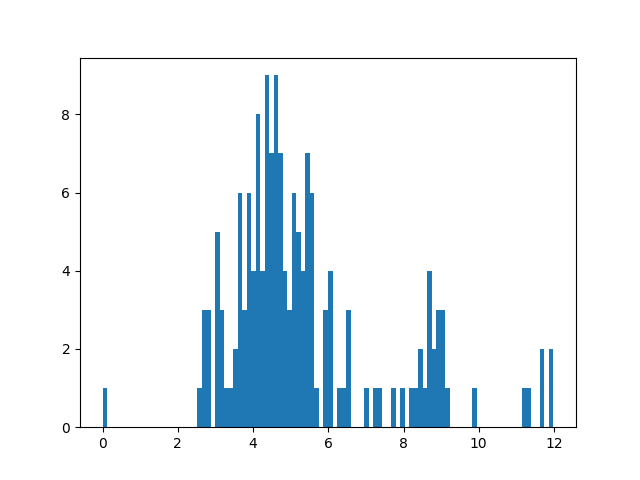

In [63]:
%matplotlib widget
plt.hist(list(label_dict.values()), bins = 100)

### Extract original segments set on Prince images

The objective is to get a dictionnary of the following sort:

In [64]:
def is_valid(name):
    return ".json" in name

def fetch_slices():
    d = {}
    # Directory containing the different prince runs on the plate
    directory_prince = os.path.join(storage_path, "20220714_plate_120_groundtruths_width_extraction")
    # Chose which runs to use
    training_runs = select_runs(run_df, focus=[-0.3, 0.], luminosity=[900, 1500]) # CAREFULL
    print(training_runs)
    # Process one plate at the time
    for run_path in training_runs:
        label_path = os.path.join(directory_prince, run_path, "Img")
        for file in os.listdir(label_path):
            if is_valid(file):
                segments = []
                path = os.path.join(label_path, file)
                with open(path) as f:
                    json_from_file = json.load(f)
                for shape in json_from_file["shapes"]:
                    if shape['shape_type'] == "line":
                        segments.append((shape['label'], shape["points"], run_path))
                if file in d:
                    print("ERROR")
                d[file] = segments    
    return d

In [65]:
segment_dict = fetch_slices()

['20220714_1426_Plate18', '20220714_1430_Plate18', '20220714_1434_Plate18', '20220714_1438_Plate18', '20220714_1520_Plate18', '20220714_1505_Plate18', '20220714_1543_Plate18', '20220714_1526_Plate18', '20220714_1511_Plate18', '20220714_1547_Plate18', '20220714_1530_Plate18', '20220714_1515_Plate18', '20220714_1551_Plate18', '20220714_1535_Plate18', '20220714_1501_Plate18', '20220714_1558_Plate18', '20220714_1539_Plate18', '20220714_1602_Plate18']


In [66]:
segment_dict

{'Img_r06_c09.json': [('w115',
   [[1367.049009384776, 2860.3753910323253],
    [1371.3242961418143, 2862.3566214807092]],
   '20220714_1430_Plate18'),
  ('w126', [[1198.9, 2804.5], [1202.0, 2803.0]], '20220714_1430_Plate18'),
  ('w125', [[1157.2, 2746.4], [1160.1, 2744.2]], '20220714_1430_Plate18'),
  ('w113',
   [[1285.7894736842106, 2648.9473684210525],
    [1288.1052631578948, 2651.2631578947367]],
   '20220714_1430_Plate18'),
  ('w114',
   [[1333.4146341463415, 2576.3414634146343],
    [1335.9756097560976, 2577.6829268292686]],
   '20220714_1430_Plate18'),
  ('w116', [[1242.6, 2906.0], [1245.3, 2905.4]], '20220714_1430_Plate18'),
  ('w117', [[1264.6, 2970.2], [1267.7, 2969.8]], '20220714_1430_Plate18'),
  ('w000',
   [[1325.4777070063694, 1997.452229299363],
    [1338.216560509554, 2004.4585987261146]],
   '20220714_1430_Plate18')],
 'Img_r03_c07.json': [('w095',
   [[1817.1, 2587.0], [1820.8, 2583.8]],
   '20220714_1434_Plate18'),
  ('w096', [[1879.3, 2635.3], [1881.3, 2631.5]], 

TEST

In [ ]:
l = [e[0] for key in segment_dict.keys() for e in segment_dict[key] ]
print(len(l))
print(len(list(set(l))))
a = list(set(l))
a.sort()
a[:10]

In [67]:
def change_extension(name):
    return name[:-5] + ".tif"

TEST

In [68]:
change_extension('Img_r02_c03.json')

'Img_r02_c03.tif'

In [69]:
def dict_to_list_seg(seg_d):
    result = []
    for key in seg_d.keys():
        for data_point in seg_d[key]:
            result.append((key, data_point[0], data_point[1], data_point[2]))
    return result

In [70]:
new = dict_to_list_seg(segment_dict)

In [71]:
print(new[:10])

[('Img_r06_c09.json', 'w115', [[1367.049009384776, 2860.3753910323253], [1371.3242961418143, 2862.3566214807092]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w126', [[1198.9, 2804.5], [1202.0, 2803.0]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w125', [[1157.2, 2746.4], [1160.1, 2744.2]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w113', [[1285.7894736842106, 2648.9473684210525], [1288.1052631578948, 2651.2631578947367]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w114', [[1333.4146341463415, 2576.3414634146343], [1335.9756097560976, 2577.6829268292686]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w116', [[1242.6, 2906.0], [1245.3, 2905.4]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w117', [[1264.6, 2970.2], [1267.7, 2969.8]], '20220714_1430_Plate18'), ('Img_r06_c09.json', 'w000', [[1325.4777070063694, 1997.452229299363], [1338.216560509554, 2004.4585987261146]], '20220714_1430_Plate18'), ('Img_r03_c07.json', 'w095', [[1817.1, 2587.0], [1820.8, 2583.8]],

In [72]:
def extract_points(list_intel, name, kept, label_d, info):
    """
    This function extracts all the data points and make the dataset.
    :param list_intel: list of data points
    :kept: list of labels that we want to keep
    :label_d: dictionnary of labels
    :info: str with infos on the dataset
    """
    target_length = 120
    slices = []
    labels = []
    # Directory containing the different prince runs on the plate
    directory_prince = os.path.join(storage_path, "20220714_plate_120_groundtruths_width_extraction")
    # Directory where we store the data
    dataset_directory = os.path.join(storage_path, "datasets", name)
    if not os.path.isdir(dataset_directory):
        os.mkdir(dataset_directory)
    for data_point in list_intel:
        tile_name = data_point[0]
        label_name = data_point[1]
        segment_coords = data_point[2]
        run_name = data_point[3]
        [point1, point2] = segment_coords
        
        label_path = os.path.join(directory_prince, run_name, "Img")
        image_name = change_extension(tile_name)  # QUICKFIX
        image_path = os.path.join(label_path, image_name)
            
        if label_name in kept:
            # Fetch the slice
            # Inversion of coordinates !
            point1 = [point1[1], point1[0]]
            point2 = [point2[1], point2[0]]
            point1 = np.array(point1)  # in image ref
            point2 = np.array(point2)
            middle_point = (point1 + point2) / 2
            im = imageio.imread(image_path)
            point1_, point2_ = expand_segment(
                point1, point2, factor=compute_factor(point1, point2, target_length)
            )
            profile = profile_line(im, point1_, point2_, mode="constant")
            profile = profile[:target_length]
            profile = profile.reshape((1, len(profile)))
            # Get the width
            width = label_d[label_name]
            # Add the point
            slices.append(profile)
            labels.append(width)
        else:
            print(f"Removed: {label_name}")
    slice_array = np.concatenate(slices, axis=0)
    label_array = np.array(labels)
    print(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")

    cv2.imwrite(os.path.join(dataset_directory, "slices.png"), slice_array)
    with open(os.path.join(dataset_directory, "labels.npy"), "wb") as f:
        np.save(f, label_array)
        
    with open(os.path.join(dataset_directory, "info.txt"), "w") as f:
        f.write(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")
        f.write(info)
        

In [73]:
extract_points(new, "test_felix_mardi", ['w111', 'w038', 'w055', 'w003', 'w049', 'w150', 'w088', 'w073', 'w141', 'w130'], label_dict, "hahahahaha")

Removed: w115
Removed: w126
Removed: w125
Removed: w113
Removed: w114
Removed: w116
Removed: w117
Removed: w000
Removed: w095
Removed: w096
Removed: w090
Removed: w089
Removed: w086
Removed: w093
Removed: w091
Removed: w092
Removed: w079
Removed: w076
Removed: w077
Removed: w078
Removed: w087
Removed: w080
Removed: w085
Removed: w081
Removed: w083
Removed: w076
Removed: w077
Removed: w079
Removed: w078
Removed: w087
Removed: w080
Removed: w081
Removed: w085
Removed: w086
Removed: w090
Removed: w089
Removed: w095
Removed: w096
Removed: w092
Removed: w091
Removed: w093
Removed: w000
Removed: w157
Removed: w159
Removed: w158
Removed: w161
Removed: w160
Removed: w154
Removed: w156
Removed: w152
Removed: w155
Removed: w153
Removed: w149
Removed: w151
Removed: w000
Removed: w132
Removed: w133
Removed: w134
Removed: w137
Removed: w138
Removed: w143
Removed: w142
Removed: w139
Removed: w140
Removed: w145
Removed: w144
Removed: w135
Removed: w136
Removed: w000
Removed: w147
Removed: w146
Remove

### Shifting dataset functions

In [74]:
RUN_DF = pd.DataFrame(d)
RUN_DF = RUN_DF.T
RUN_DF

focus  luminosity
20220714_1405_Plate18    0.5      1100.0
20220714_1409_Plate18    0.4      1100.0
20220714_1413_Plate18    0.3      1100.0
20220714_1417_Plate18    0.2      1100.0
20220714_1422_Plate18    0.1      1100.0
20220714_1426_Plate18    0.0      1100.0
20220714_1430_Plate18   -0.1      1100.0
20220714_1434_Plate18   -0.2      1100.0
20220714_1438_Plate18   -0.3      1100.0
20220714_1444_Plate18   -0.4      1100.0
20220714_1451_Plate18   -0.5      1100.0
20220714_1520_Plate18    0.0       900.0
20220714_1505_Plate18   -0.1       900.0
20220714_1543_Plate18   -0.2       900.0
20220714_1526_Plate18    0.0      1000.0
20220714_1511_Plate18   -0.1      1000.0
20220714_1547_Plate18   -0.2      1000.0
20220714_1530_Plate18    0.0      1200.0
20220714_1515_Plate18   -0.1      1200.0
20220714_1551_Plate18   -0.2      1200.0
20220714_1535_Plate18    0.0      1300.0
20220714_1501_Plate18   -0.1      1300.0
20220714_1558_Plate18   -0.2      1300.0
20220714_1539_Plate18    0.0      1500.0
20220714_1602_Plate18   -0.2      1500.0

In [75]:
def select_df(df, focus=[-0.3, 0.3], luminosity=[1000, 1000]):
    selected_df = df[
        (focus[0] <= df["focus"])
        & (df["focus"] <= focus[1])
        & (luminosity[0] <= df["luminosity"])
        & (df["luminosity"] <= luminosity[1])
    ]
    return selected_df

def select_runs(df, focus=[-0.3, 0.3], luminosity=[1000, 1000]):
    selected_df = select_df(df, focus = focus, luminosity = luminosity)
    keys = selected_df.index
    return list(keys)

In [76]:
def change_focus(name, value):
    "Return the name of the run with `value` in focus"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['focus'] == np.round(current_focus + value, 2) ) & (RUN_DF['luminosity'] == current_lum)]
    if len(select_df.index) == 1:
        return select_df.index[0]
    else:
        print(f"Number of row found: {len(select_df.index)}")
        return None

In [77]:
# TEST
name = "20220714_1451_Plate18"

In [78]:
print(name)
name = change_focus(name, -0.1)
print(name)

20220714_1451_Plate18
Number of row found: 0
None


In [79]:
def decr_focus(name):
    "Return the name of the run with -0.1 in focus"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['focus'] == np.round(current_focus - 0.1, 2) ) & (RUN_DF['luminosity'] == current_lum)]
    if len(select_df.index) == 1:
        return select_df.index[0]
    else:
        print(f"Number of row found: {len(select_df.index)}")
        return None

TEST

In [81]:
def change_lum(name, value):
    "Return the name of the run with +100 in luminosity"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['focus'] == current_focus) & (RUN_DF['luminosity'] == np.round(current_lum + value))]
    if len(select_df.index) == 1:
        return select_df.index[0]
    else:
        print(f"Number of row found: {len(select_df.index)}")
        return None

In [82]:
change_lum("20220714_1438_Plate18", 100.)

Number of row found: 0


In [83]:
change_lum("20220714_1430_Plate18", 200.)

'20220714_1501_Plate18'

In [84]:
change_lum("20220714_1430_Plate18", -200.)

'20220714_1505_Plate18'

TEST

In [85]:
def incr_lum(name):
    "Return the name of the run with -100 in luminosity"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['focus'] == current_focus) & (RUN_DF['luminosity'] == np.round(current_lum - 100.))]
    if len(select_df.index) == 1:
        return select_df.index[0]
    else:
        print(f"Number of row found: {len(select_df.index)}")
        return None

In [86]:
def get_focuses(name):
    "Return a list of names of runs with same luminosity but differrent focuses (name is included)"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['focus'] == current_focus)]
    return list(select_df.index)

TEST

In [26]:
get_focuses("20220714_1438_Plate18")

['20220714_1438_Plate18']

In [27]:
get_focuses("20220714_1434_Plate18")

['20220714_1434_Plate18',
 '20220714_1543_Plate18',
 '20220714_1547_Plate18',
 '20220714_1551_Plate18',
 '20220714_1558_Plate18',
 '20220714_1602_Plate18']

In [28]:
get_focuses("20220714_1426_Plate18")

['20220714_1426_Plate18',
 '20220714_1520_Plate18',
 '20220714_1526_Plate18',
 '20220714_1530_Plate18',
 '20220714_1535_Plate18',
 '20220714_1539_Plate18']

In [87]:
def get_luminosities(name):
    "Return a list of names of runs with same luminosity but differrent focuses (name is included)"
    current_focus = RUN_DF.loc[name]['focus']
    current_lum = RUN_DF.loc[name]['luminosity']
    select_df = RUN_DF[(RUN_DF['luminosity'] == current_lum)]
    return list(select_df.index)

TEST

In [30]:
get_luminosities("20220714_1434_Plate18")

['20220714_1405_Plate18',
 '20220714_1409_Plate18',
 '20220714_1413_Plate18',
 '20220714_1417_Plate18',
 '20220714_1422_Plate18',
 '20220714_1426_Plate18',
 '20220714_1430_Plate18',
 '20220714_1434_Plate18',
 '20220714_1438_Plate18',
 '20220714_1444_Plate18',
 '20220714_1451_Plate18']

In [31]:
get_luminosities("20220714_1535_Plate18")

['20220714_1535_Plate18', '20220714_1501_Plate18', '20220714_1558_Plate18']

### Making the actual datasets

#### Seperating test and train sets

PARAMETERS

In [88]:
seed = 1000

Seperating sets

In [91]:
all_keys = list(label_dict.keys())
random.seed(seed)
random.shuffle(all_keys)
train = all_keys[:-50]
test = all_keys[-50:]
print(f"For a number of {len(all_keys)}, train: {len(train)}, test: {len(test)}")

For a number of 161, train: 111, test: 50


#### 1/ Single focus datasets with default illumination

In [92]:
info = lambda value: f"""
This dataset contains data points with normal illumination and all the same focus,
which is shifted by a value of {value}
"""

In [93]:
def shift_dataset(dataset, value):
    "Take as input a data set and shifts all points to have a focus of `value`"
    new_dataset = []
    for data_point in dataset:
        tile_name = data_point[0]
        label_name = data_point[1]
        segment_coords = data_point[2]
        run_name = data_point[3]
        new_run_name = change_focus(run_name, value)
        if new_run_name:
            new_dataset.append((tile_name, label_name, segment_coords, new_run_name))
    print(f"Number of datapoints lost: {len(dataset) - len(new_dataset)}")
    return new_dataset
        

In [216]:
len(shift_dataset(new, 0.5))

Number of datapoints lost: 0


221

In [94]:
len(shift_dataset(new, 0.5))

Number of datapoints lost: 0


221

In [98]:
test = [key for key in all_keys if key not in train]

In [97]:
train = ['w111',
 'w038',
 'w055',
 'w003',
 'w049',
 'w150',
 'w088',
 'w073',
 'w141',
 'w130',
 'w065',
 'w093',
 'w131',
 'w064',
 'w012',
 'w124',
 'w110',
 'w158',
 'w115',
 'w063',
 'w153',
 'w143',
 'w056',
 'w042',
 'w046',
 'w101',
 'w081',
 'w013',
 'w008',
 'w037',
 'w140',
 'w067',
 'w030',
 'w082',
 'w132',
 'w029',
 'w149',
 'w024',
 'w062',
 'w048',
 'w126',
 'w032',
 'w113',
 'w028',
 'w087',
 'w090',
 'w172',
 'w105',
 'w045',
 'w136',
 'w054',
 'w070',
 'w009',
 'w094',
 'w123',
 'w119',
 'w122',
 'w000',
 'w089',
 'w052',
 'w047',
 'w106',
 'w104',
 'w107',
 'w109',
 'w117',
 'w058',
 'w027',
 'w168',
 'w075',
 'w020',
 'w170',
 'w072',
 'w135',
 'w142',
 'w035',
 'w031',
 'w096',
 'w099',
 'w171',
 'w041',
 'w157',
 'w091',
 'w147',
 'w061',
 'w108',
 'w133',
 'w121',
 'w059',
 'w162',
 'w163',
 'w068',
 'w103',
 'w095',
 'w138',
 'w145',
 'w129',
 'w015',
 'w004',
 'w076',
 'w083',
 'w010',
 'w051',
 'w043',
 'w018',
 'w139',
 'w007',
 'w002',
 'w127',
 'w021',
 'w154',
 'w036',
 'w080',
 'w114',
 'w116',
 'w166',
 'w156',
 'w134',
 'w125',
 'w074',
 'w023',
 'w039']

In [163]:
for focus_shift in [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    extract_points(shift_dataset(new, focus_shift), f"single_focus_{focus_shift}_train", train, label_dict, info(focus_shift))

Number of datapoints lost: 0
Slice array: (157, 120) Label array: (157,)


In [218]:
for focus_shift in [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    extract_points(shift_dataset(new, focus_shift), 
                   f"single_focus_{focus_shift}_test", test, label_dict, info(focus_shift))

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w135
Removed: w136
Removed: w000
Removed: w147
Removed: w150
Removed: w149
Removed: w153
Removed: w154
Removed: w156
Removed: w157
Removed: w158
Removed: w168
Removed: w170
Removed: w171
Removed: w000
Removed: w162
Removed: w163
Removed: w166
Removed: w172
Removed: w035
Removed: w036
Removed: w037
Removed: w038
Removed: w039
Removed: w041
Removed: w042
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w000
Removed: w027
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w032
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w002
Removed: w003
Removed: w002
Removed: w003
Removed: w004
Removed: w007
Removed: w008
Removed: w009
Removed: w010
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w018
Removed: w046
Removed: w048
Removed: w052
Removed: w045
Removed: w043
Removed: w049
Removed: w055
Removed: w056
Removed: w059
Removed: w058
Removed: w061
Removed: w063
Removed: w062
Removed: w064
Remove

Number of datapoints lost: 0
Removed: w115
Removed: w126
Removed: w125
Removed: w113
Removed: w114
Removed: w116
Removed: w117
Removed: w000
Removed: w095
Removed: w096
Removed: w090
Removed: w089
Removed: w093
Removed: w091
Removed: w088
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w083
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w088
Removed: w090
Removed: w089
Removed: w095
Removed: w096
Removed: w091
Removed: w093
Removed: w000
Removed: w157
Removed: w158
Removed: w154
Removed: w156
Removed: w153
Removed: w149
Removed: w150
Removed: w000
Removed: w132
Removed: w133
Removed: w134
Removed: w138
Removed: w143
Removed: w142
Removed: w141
Removed: w139
Removed: w140
Removed: w145
Removed: w135
Removed: w136
Removed: w000
Removed: w147
Removed: w150
Removed: w149
Removed: w153
Removed: w154
Removed: w156
Removed: w157
Removed: w158
Removed: w168
Removed: w170
Removed: w171
Removed: w000
Removed: w162
Removed: w163
Removed: w166
Removed: w172
Remov

In [101]:
for focus_shift in [0.0]:
    extract_points(shift_dataset(new, focus_shift), 
                   f"single_focus_{focus_shift}_test", test, label_dict, info(focus_shift))

Number of datapoints lost: 0
Removed: w115
Removed: w126
Removed: w125
Removed: w113
Removed: w114
Removed: w116
Removed: w117
Removed: w000
Removed: w095
Removed: w096
Removed: w090
Removed: w089
Removed: w093
Removed: w091
Removed: w088
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w083
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w088
Removed: w090
Removed: w089
Removed: w095
Removed: w096
Removed: w091
Removed: w093
Removed: w000
Removed: w157
Removed: w158
Removed: w154
Removed: w156
Removed: w153
Removed: w149
Removed: w150
Removed: w000
Removed: w132
Removed: w133
Removed: w134
Removed: w138
Removed: w143
Removed: w142
Removed: w141
Removed: w139
Removed: w140
Removed: w145
Removed: w135
Removed: w136
Removed: w000
Removed: w147
Removed: w150
Removed: w149
Removed: w153
Removed: w154
Removed: w156
Removed: w157
Removed: w158
Removed: w168
Removed: w170
Removed: w171
Removed: w000
Removed: w162
Removed: w163
Removed: w166
Removed: w172
Remov

#### 2/ Single illumination datasets with perfect focus

In [197]:
info = lambda value: f"""
This dataset contains data points with {value} illumination compared to default and a focus of 0.0 (perfect focus)
"""

In [198]:
print(info(100))


This dataset contains data points with 100 illumination compared to default and a focus of 0.0 (perfect focus)



In [202]:
def shift_dataset_lum(dataset, value):
    "Take as input a data set and shifts all points to have a focus of `value`"
    new_dataset = []
    for data_point in dataset:
        tile_name = data_point[0]
        label_name = data_point[1]
        segment_coords = data_point[2]
        run_name = data_point[3]
        new_run_name = change_lum(run_name, value)
        if new_run_name:
            new_dataset.append((tile_name, label_name, segment_coords, new_run_name))
    print(f"Number of datapoints lost: {len(dataset) - len(new_dataset)}")
    return new_dataset
        

In [203]:
len(shift_dataset_lum(new, 100))

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

158

In [209]:
for lum_shift in [-200, -100, 100, 200, 400]:
    extract_points(shift_dataset_lum(new, lum_shift), 
                   f"single_lum_{lum_shift}_focus_{0}_train", train, label_dict, info(lum_shift))

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w159
Removed: w161
Removed: w160
Removed: w152
Removed: w155
Removed: w151
Removed: w137
Removed: w144
Removed: w146
Removed: w148
Removed: w151
Removed: w152
Removed: w155
Removed: w160
Removed: w161
Removed: w159
Removed: w169
Removed: w164
Removed: w165
Removed: w034
Removed: w033
Removed: w040
Removed: w025
Removed: w026
Removed: w033
Removed: w011
Removed: w014
Removed: w022
Removed: w019
Removed: w001
Removed: w001
Removed: w011
Removed: w005
Removed: w006
Removed: w014
Removed: w016
Removed: w019
Removed: w022
Removed: w017
Slice array: (107, 120) Label array: (107,)
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found

In [210]:
for lum_shift in [-200, -100, 100, 200, 400]:
    extract_points(shift_dataset_lum(new, lum_shift), 
                   f"single_lum_{lum_shift}_focus_{0}_test", test, label_dict, info(lum_shift))

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w036
Removed: w037
Removed: w038
Removed: w039
Removed: w041
Removed: w042
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w000
Removed: w027
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w032
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w002
Removed: w003
Removed: w002
Removed: w003
Removed: w004
Removed: w007
Removed: w008
Removed: w009
Removed: w010
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w018
Slice array: (51, 120) Label array: (51,)
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Num

#### 3/ Multiple illumination with optimal focus

In [221]:
info = """
This dataset contains data points with varying illumination and a focus of 0.0 (perfect focus)
"""

In [226]:
def general_dataset_focused(dataset):
    final_dataset = []
    for value in [-200, -100, 100, 200, 400]:
        new_dataset = []
        for data_point in dataset:
            tile_name = data_point[0]
            label_name = data_point[1]
            segment_coords = data_point[2]
            run_name = data_point[3]
            new_run_name = change_lum(run_name, value)
            if new_run_name:
                new_dataset.append((tile_name, label_name, segment_coords, new_run_name))
                final_dataset.append((tile_name, label_name, segment_coords, new_run_name))
        print(f"Number of points for {value}: {len(new_dataset)}")
        
    return final_dataset
        

In [227]:
len(general_dataset_focused(new))

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

782

In [228]:
extract_points(general_dataset_focused(new), 
                   f"focused_with_varying_lum_train", train, label_dict, info)

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w086
Removed: w092
Removed: w079
Removed: w077
Removed: w078
Removed: w085
Removed: w077
Removed: w079
Removed: w078
Removed: w085
Removed: w086
Removed: w092
Removed: w159
Removed: w161
Removed: w160
Removed: w152
Removed: w155
Removed: w151
Removed: w137
Removed: w144
Removed: w146
Removed: w148
Removed: w151
Removed: w152
Removed: w155
Removed: w160
Removed: w161
Removed: w159
Removed: w169
Removed: w164
Removed: w165
Removed: w034
Removed: w033
Removed: w040
Removed: w025
Removed: w026
Removed: w033
Removed: w011
Removed: w014
Removed: w022
Removed: w019
Removed: w001
Removed: w001
Removed: w011
Removed: w005
Removed: w006
Removed: w014
Removed: w016
Removed: w019
Removed: w022
Removed: w017
Removed: w086
Removed: w092
Removed: w079
Removed: w077
Removed: w078
Removed: w085
Removed: w077
Removed: w079
Removed: w078
Removed: w085
Removed: w086
Removed: w092
Removed: w159
Removed: w161
Removed: w160
Removed: w152
Removed: w155
Removed: w151
Removed: w137
Removed: w144
Remove

In [229]:
extract_points(general_dataset_focused(new), 
                   f"focused_with_varying_lum_test", test, label_dict, info)

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w027
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w032
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w002
Removed: w003
Removed: w002
Removed: w003
Removed: w004
Removed: w007
Removed: w008
Removed: w009
Removed: w010
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w018
Removed: w115
Removed: w126
Removed: w125
Removed: w113
Removed: w114
Removed: w116
Removed: w117
Removed: w000
Removed: w095
Removed: w096
Removed: w090
Removed: w089
Removed: w093
Removed: w091
Removed: w088
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w083
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w088
Removed: w090
Removed: w089
Removed: w095
Removed: w096
Removed: w091
Removed: w093
Removed: w000
Removed: w157
Removed: w158
Removed: w154
Removed: w156
Removed: w153
Removed: w149
Removed: w150
Removed: w000
Removed: w132
Removed: w133
Removed: w134
Removed: w138
Removed: w143
Remove

#### 4/ Multiple illumination and varying focus

In [233]:
info = """
This dataset contains data points with varying illumination and varying focus (from -0.1 to 0.1)
"""

In [234]:
def general_extended_dataset(dataset):
    final_dataset = []
    for focus in [0.1, 0.0, -0.1]:
        focus_dataset = shift_dataset(dataset, focus)
        for value in [-200, -100, 100, 200, 400]:
            for data_point in focus_dataset:
                tile_name = data_point[0]
                label_name = data_point[1]
                segment_coords = data_point[2]
                run_name = data_point[3]
                new_run_name = change_lum(run_name, value)
                if new_run_name:
                    final_dataset.append((tile_name, label_name, segment_coords, new_run_name))
    return final_dataset

In [235]:
len(general_extended_dataset(new))

Number of datapoints lost: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Numbe

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

1777

In [236]:
extract_points(general_extended_dataset(new), 
                   f"varying_lum_and_focus_train", train, label_dict, info)

Number of datapoints lost: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Numbe

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w040
Removed: w025
Removed: w026
Removed: w033
Removed: w011
Removed: w014
Removed: w022
Removed: w019
Removed: w001
Removed: w001
Removed: w011
Removed: w005
Removed: w006
Removed: w014
Removed: w016
Removed: w019
Removed: w022
Removed: w017
Removed: w086
Removed: w092
Removed: w079
Removed: w077
Removed: w078
Removed: w085
Removed: w077
Removed: w079
Removed: w078
Removed: w085
Removed: w086
Removed: w092
Removed: w159
Removed: w161
Removed: w160
Removed: w152
Removed: w155
Removed: w151
Removed: w137
Removed: w144
Removed: w146
Removed: w148
Removed: w151
Removed: w152
Removed: w155
Removed: w160
Removed: w161
Removed: w159
Removed: w169
Removed: w164
Removed: w165
Removed: w034
Removed: w033
Removed: w040
Removed: w025
Removed: w026
Removed: w033
Removed: w011
Removed: w014
Removed: w022
Removed: w019
Removed: w001
Removed: w001
Removed: w011
Removed: w005
Removed: w006
Removed: w014
Removed: w016
Removed: w019
Removed: w022
Removed: w017
Removed: w086
Removed: w092
Remove

In [237]:
extract_points(general_extended_dataset(new), 
                   f"varying_lum_and_focus_test", test, label_dict, info)

Number of datapoints lost: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Numbe

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of row found: 0
Number of r

Removed: w154
Removed: w156
Removed: w153
Removed: w149
Removed: w150
Removed: w000
Removed: w132
Removed: w133
Removed: w134
Removed: w138
Removed: w143
Removed: w142
Removed: w141
Removed: w139
Removed: w140
Removed: w145
Removed: w135
Removed: w136
Removed: w000
Removed: w147
Removed: w150
Removed: w149
Removed: w153
Removed: w154
Removed: w156
Removed: w157
Removed: w158
Removed: w168
Removed: w170
Removed: w171
Removed: w000
Removed: w162
Removed: w163
Removed: w166
Removed: w172
Removed: w035
Removed: w036
Removed: w037
Removed: w038
Removed: w039
Removed: w041
Removed: w042
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w000
Removed: w027
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w032
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w002
Removed: w003
Removed: w002
Removed: w003
Removed: w004
Removed: w007
Removed: w008
Removed: w009
Removed: w010
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Remove

Removed: w166
Removed: w172
Removed: w035
Removed: w036
Removed: w037
Removed: w038
Removed: w039
Removed: w041
Removed: w042
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w000
Removed: w027
Removed: w028
Removed: w029
Removed: w030
Removed: w031
Removed: w032
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w002
Removed: w003
Removed: w002
Removed: w003
Removed: w004
Removed: w007
Removed: w008
Removed: w009
Removed: w010
Removed: w012
Removed: w013
Removed: w015
Removed: w020
Removed: w021
Removed: w018
Removed: w115
Removed: w126
Removed: w125
Removed: w113
Removed: w114
Removed: w116
Removed: w117
Removed: w000
Removed: w095
Removed: w096
Removed: w090
Removed: w089
Removed: w093
Removed: w091
Removed: w088
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w083
Removed: w076
Removed: w087
Removed: w080
Removed: w081
Removed: w088
Removed: w090
Removed: w089
Removed: w095
Removed: w096
Removed: w091
Removed: w093
Remove